In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("CH21-1-SingleAGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-1-SingleAGENT


# Single Agent 

프롬프트를 생성해주는 에이전트 

In [ ]:
from typing import List, Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel
import uuid

from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

## 1. 정보 수집

프롬프트 작성 위한 정보 수집 용도

In [ ]:
# 사용자로부터 수집할 정보에 대한 시스템 프롬프트 템플릿

template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify! Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool."""

In [ ]:
# 사용자 대화에 시스템 메시지를 추가
def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages

In [6]:
class PromptInstructions(BaseModel):
    """Instructions on how to prompt the LLM."""

    objective: str
    variables: List[str]
    constraints: List[str]
    requirements: List[str]

In [ ]:
# 모델 정의 + 도구 연결 
llm = ChatOpenAI(model="gpt-4o-mini",temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

In [ ]:
# 정보 수집 위한 함수 정의 
def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

## 2. 프롬프트 생성

In [ ]:
# 프롬프트 생성 위한 시스템 프롬프트 
prompt_system = """Based on the following requirements, write a good prompt template:

{reqs}"""

In [ ]:
# 도구 호출 이후의 메시지를 추출하고 프롬프트 생성 메시지 구성 
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []
    for m in messages:
        if isinstance(m, AIMessage) and m.tool_calls:
            tool_call = m.tool_calls[0]["args"]
            print(tool_call)
        elif isinstance(m, ToolMessage):
            continue
        elif tool_call is not None:
            other_msgs.append(m)
    return [SystemMessage(content=prompt_system.format(reqs=tool_call))] + other_msgs

# 프롬프트 생성 체인 함수
def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages": [response]}

## 3. Graph

In [11]:
def get_state(state) -> Literal["prompt", "info", "__end__"]:
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "prompt"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [12]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()
workflow = StateGraph(State)

workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)

workflow.add_conditional_edges("info", get_state)
workflow.add_edge("prompt", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

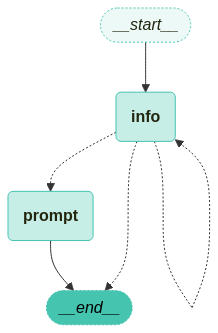

In [13]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 4. 실행

In [ ]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [ ]:
while True:
    # 사용자 종료 선언 시 처리 
    user = input("User (q/Q to quit): ")
    if user in {"q", "Q"}:
        print("AI: Byebye")
        break
    output = None

    # 실행 
    for output in graph.stream(
        {"messages": [HumanMessage(content=user)]}, config=config, stream_mode="updates"
    ):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

    # output이 존재하고, 그 안에 'prompt' 키가 있을 경우
    if output and "prompt" in output:
        print("Done!")

================================== Ai Message ==================================

빙수 레시피를 작성하기 위한 프롬프트를 만들기 위해 몇 가지 정보를 더 필요로 합니다.

1. **프롬프트의 목표**: 빙수 레시피를 작성하는 것 외에 어떤 특정한 목표가 있나요? 예를 들어, 특정 재료를 사용하거나 특정 스타일의 빙수를 만드는 것과 같은 목표가 있을 수 있습니다.

2. **프롬프트 템플릿에 전달될 변수**: 어떤 변수들이 프롬프트에 포함되어야 하나요? 예를 들어, 재료 목록, 서빙 인원수, 조리 시간 등이 있을 수 있습니다.

3. **출력에서 하지 말아야 할 제약 조건**: 출력에서 어떤 내용이 포함되지 않아야 하나요? 예를 들어, 특정 재료를 사용하지 않거나, 너무 복잡한 조리법을 피해야 하는 등의 제약이 있을 수 있습니다.

4. **출력에서 반드시 지켜야 할 요구 사항**: 출력이 반드시 따라야 할 요구 사항은 무엇인가요? 예를 들어, 레시피가 간단해야 하거나, 특정 영양 정보를 포함해야 하는 등의 요구 사항이 있을 수 있습니다.

이 정보를 제공해 주시면, 적절한 프롬프트 템플릿을 작성할 수 있습니다!
================================== Ai Message ==================================

감사합니다! 이제 추가 정보를 요청하겠습니다.

1. **프롬프트 템플릿에 전달될 변수**: 어떤 변수들이 프롬프트에 포함되어야 하나요? 예를 들어, 사용하고 싶은 재료, 서빙 인원수, 조리 시간 등이 있을 수 있습니다.

2. **출력에서 하지 말아야 할 제약 조건**: 출력에서 어떤 내용이 포함되지 않아야 하나요? 예를 들어, 특정 재료를 사용하지 않거나, 너무 복잡한 조리법을 피해야 하는 등의 제약이 있을 수 있습니다.

3. **출력에서 반드시 지켜야 할 요구 사항**: 출력이 반드시 따라야 할 요구 사항은 무엇인가요? 예를 들어, 레시피

--------
** End of Documents **